http://docs.pymc.io/notebooks/GLM-hierarchical.html or a random effects model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
from pandas.plotting import scatter_matrix
from scipy.stats import ttest_ind, linregress, norm
from scipy.stats.mstats import zscore
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import scale
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

%matplotlib inline
tracts_data_path = 'data/features.csv'

C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
dtypes = {'GEOID' : str,
          'place_geoid' : str,
          'state' : str,
          'county' : str}

df = pd.read_csv(tracts_data_path, encoding='utf-8', dtype=dtypes)
df = df.rename(columns={'GEOID' : 'tract'}).set_index('tract')
assert df.index.is_unique

In [3]:
print(len(df))
df.head()

12328


,land_area,place_geoid,place_name,total_pop,median_age,pct_hispanic,pct_white,pct_black,pct_asian,pct_single_fam_detached,...,pct_burden,median_gross_rent_k,med_income_k,med_home_value_k,pct_white_change_2012_2015,clist_count,prop_count,bias_diff,bias_ratio,bias_log
tract,,,,,,,,,,,,,,,,,,,,,
01073000100,7549578,0107000,"Birmingham, AL",2970.0,32.2,0.046,0.171,0.785,0.000,0.705,...,0.604,0.754,24.359,68.4,0.014,3,2.150039,0.849961,1.269826,0.238880
01073000300,2093104,0107000,"Birmingham, AL",2494.0,36.5,0.180,0.046,0.672,0.084,0.326,...,0.534,0.552,20.425,65.3,-0.022,1,2.852092,-1.852092,0.519198,-0.655469
01073000400,8001582,0107000,"Birmingham, AL",3437.0,30.6,0.007,0.079,0.908,0.000,0.897,...,0.747,0.912,21.759,60.7,0.025,2,2.120786,-0.120786,0.961296,-0.039473
01073000500,4819145,0107000,"Birmingham, AL",3735.0,35.8,0.014,0.050,0.929,0.000,0.546,...,0.547,0.534,21.430,53.7,0.011,0,3.426167,-3.426167,0.225929,-1.487534
01073000700,3520564,0107000,"Birmingham, AL",2562.0,25.4,0.025,0.000,0.977,0.000,0.569,...,0.773,0.505,15.833,52.4,-0.001,0,2.135412,-2.135412,0.318937,-1.142761


In [4]:
# dummies representing if each race is majority in tract
df['dummy_white'] = df['pct_white'].map(lambda x: 1 if x > 0.5 else 0)
df['dummy_asian'] = df['pct_asian'].map(lambda x: 1 if x > 0.5 else 0)
df['dummy_black'] = df['pct_black'].map(lambda x: 1 if x > 0.5 else 0)
df['dummy_hispanic'] = df['pct_hispanic'].map(lambda x: 1 if x > 0.5 else 0)

## determine if tracts are over or under represented

In [5]:
overrepresent_var = 'bias_ratio'
overrepresent_value = 1

In [6]:
# divide data into two subsets: overrepresented vs proportionately&under-represented
mask = df[overrepresent_var] > overrepresent_value
over = df[mask]
under = df[~mask]
print(len(over), len(under))

3078 9250


In [7]:
# make a dummy to indicate if tract is overrepresented
df['is_over'] = df[overrepresent_var].map(lambda x: 1 if x > overrepresent_value else 0)
df['is_over'].value_counts()

0    9250
1    3078
Name: is_over, dtype: int64

In [8]:
# get a set of all predictor variables
cols = ['bias_diff', 'bias_ratio', 'bias_log', 'centroid', 'clist_count', 'county', 
        'geometry', 'is_over', 'land_area', 'lat_city_center', 'lng_city_center',
        'place_geoid', 'place_name', 'prop_count', 'state', 'pct_white_change_2012_2015']
predictors_all = df.drop(columns=cols).columns

## Race

In [9]:
# what proportion of tracts with each of these races as the majority is over-represented?
white_tracts = df[df['dummy_white']==1]
white_odds = white_tracts['is_over'].sum() / len(white_tracts)

asian_tracts = df[df['dummy_asian']==1]
asian_odds = asian_tracts['is_over'].sum() / len(asian_tracts)

black_tracts = df[df['dummy_black']==1]
black_odds = black_tracts['is_over'].sum() / len(black_tracts)

hisp_tracts = df[df['dummy_hispanic']==1]
hisp_odds = hisp_tracts['is_over'].sum() / len(hisp_tracts)

print(white_odds, asian_odds, black_odds, hisp_odds)
print(white_odds / asian_odds)
print(white_odds / black_odds)
print(white_odds / hisp_odds)

0.3662000823384109 0.2183406113537118 0.167933405718422 0.11125886524822695
1.6771963771099219
2.1806267834073907
3.2914238476312945


Majority white tracts are overrepresented on Craigslist 2x as often as majority black tracts and 3x  as often as majority hispanic tracts.

## Gini

In [10]:
# gini coefficient measures how evenly some value is distributed among a set of buckets
# we can measure how evenly listings are distributed among tracts
def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area

In [11]:
# nationwide
print(gini(df['clist_count']))
print(gini(df['prop_count']))
print(gini(df['count_renter_occupied_units']))

0.7958107050169203
0.539665690899946
0.38384089826328704


^^ prop_count is a function of per-city count_renter_occupied_units, but their gini coefficients don't match nationwide because prop_count is assigned as per-city proportions, not nationwide.

In [12]:
# now examine gini coefficients for each city
data = {}
for name, group in df.groupby('place_name'):
    
    data[name] = {'clist_gini' : gini(group['clist_count']),
                  'prop_gini' : gini(group['prop_count'])}
    
ginis = pd.DataFrame(data).T
ginis['ratio'] = ginis['clist_gini'] / ginis['prop_gini']
ginis.sort_values(by = 'ratio', ascending=False).round(3)

,clist_gini,prop_gini,ratio
"Hartford, CT",0.826,0.262,3.155
"Miami, FL",0.789,0.284,2.783
"Philadelphia, PA",0.756,0.274,2.761
"Boston, MA",0.721,0.266,2.709
"Milwaukee, WI",0.769,0.290,2.654
"Buffalo, NY",0.616,0.236,2.608
"Providence, RI",0.591,0.229,2.579
"Detroit, MI",0.781,0.310,2.516
"Sacramento, CA",0.679,0.270,2.511
"Cleveland, OH",0.727,0.290,2.509


Higher gini coefficient for actual craigslist listings suggests they are more concentrated into fewer tracts than a proportional distribution would be.

## *t*-tests and effect sizes for significant differences in variables

Divide the data into two subsets: overrepresented and underrepresented, then test if variables' means differ significantly between them.

In [13]:
# effect size: as cohen's d
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    d = (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)
    return d

def test_variables(subset1, subset2, variables):
    test_results = {}
    for var in variables:
        a = subset1[var]
        b = subset2[var]
        t_statistic, p_value = ttest_ind(a=a, b=b, equal_var=False, nan_policy='omit')
        diff = subset1[var].mean() - subset2[var].mean()
        d_value = cohen_d(x=a, y=b)
        test_results[var] = {'diff_mean' : round(diff, 3),
                             't_stat' : round(t_statistic, 2),
                             'p_val' : round(p_value, 3),
                             'cohen_d' : round(d_value, 2)}
    return test_results

In [14]:
# variables' effect sizes between over and underrepresented tracts
predictors_no_dummies = [p for p in predictors_all if 'dummy' not in p]
results = test_variables(over, under, predictors_no_dummies)
effect_sizes = pd.DataFrame(results).T.sort_values('cohen_d', ascending=False)
effect_sizes.reindex(columns=['cohen_d', 'diff_mean', 'p_val'])

,cohen_d,diff_mean,p_val
pct_bachelors_or_higher,0.80,0.171,0.000
med_income_k,0.59,17.104,0.000
pct_white,0.58,0.170,0.000
pct_college_grad_student,0.53,0.098,0.000
median_gross_rent_k,0.49,0.179,0.000
pct_20_34,0.39,0.039,0.000
pct_english_only,0.37,0.093,0.000
pct_nonrelatives_household,0.36,0.022,0.000
med_home_value_k,0.33,74.523,0.000
count_renter_occupied_units,0.13,80.796,0.000


"Cohen suggested that d=0.2 be considered a 'small' effect size, 0.5 represents a 'medium' effect size and 0.8 a 'large' effect size. This means that if two groups' means don't differ by 0.2 standard deviations or more, the difference is trivial, even if it is statistically signficant."

Perhaps we can interpret small-medium effect size as absolute value 0.3 <= x < 0.5?

d is not affected by units/sizes. So income and income_k will have same d.

In [15]:
# look at some smaller subset of key variables of interest, per city
predictors_key = ['pct_white', 'renter_household_size', 'pct_below_poverty', 'pct_20_34',
                  'pct_bachelors_or_higher', 'med_income_k', 'median_gross_rent_k']

def significance(p):
    if p <= 0.01:
        return '*'
    elif p <= 0.05:
        return '*'
    else:
        return ''

city_results = {}
for city, group in df.groupby('place_name'):
    mask = group[overrepresent_var] > 1
    group_over = group[mask]
    group_under = group[~mask]
    group_results = test_variables(group_over, group_under, predictors_key)
    var_d = {k:'{:.2f}{}'.format(v['cohen_d'], significance(v['p_val'])) for k, v in group_results.items()}
    city_results[city] = var_d

In [16]:
city_effect_sizes = pd.DataFrame(city_results).T
city_effect_sizes.index = city_effect_sizes.index.map(lambda x: x.split(', ')[0])
city_effect_sizes.head()
#city_effect_sizes.sort_values(by='mean_travel_time_work')

,med_income_k,median_gross_rent_k,pct_20_34,pct_bachelors_or_higher,pct_below_poverty,pct_white,renter_household_size
Atlanta,0.37,0.55*,0.31,0.58*,-0.37*,0.48*,-0.38*
Austin,0.44*,0.45*,-0.01,0.69*,-0.23,0.69*,-0.38*
Baltimore,0.80*,0.71*,1.07*,1.32*,-0.59*,1.15*,-0.71*
Birmingham,0.79*,0.89*,0.01,0.71*,-0.87*,0.50*,-0.10
Boston,0.41*,1.14*,1.26*,1.36*,0.03,0.98*,-1.24*


## Inspect the predictors' relationships with each other

and reduce multicollinearity among the predictors

In [17]:
# these predictor vars have the highest pairwise correlations
correlations = df[sorted(predictors_no_dummies)].corr()
correlations.stack().abs().sort_values(ascending=False)[len(predictors_no_dummies):].drop_duplicates().head(10)

pop_density_k_km         renter_occupied_units_km    0.935369
pct_foreign_born         pct_english_only            0.868093
pct_renting              med_rooms_in_house          0.816963
pct_hispanic             pct_english_only            0.811745
pct_single_fam_detached  pct_renting                 0.753678
med_income_k             pct_below_poverty           0.745893
median_gross_rent_k      med_income_k                0.737837
med_income_k             pct_bachelors_or_higher     0.734205
med_rooms_in_house       pct_single_fam_detached     0.726489
pct_commute_drive_alone  pop_density_k_km            0.722806
dtype: float64

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(correlations, cmap=plt.cm.PiYG_r)
fig.colorbar(cax, fraction=0.045, pad=0.02)
plt.xticks(range(len(correlations.columns)), correlations.columns, rotation=90)
plt.yticks(range(len(correlations.columns)), correlations.columns)
plt.savefig('images/correlation_matrix.jpg', bbox_inches='tight', dpi=300)
plt.close()

In [19]:
# matrix of scatter plots for a subset of explanatory variables
X = df[predictors_key]
plots_array = scatter_matrix(X, figsize=(35, 35), alpha=0.2, s=2, diagonal='kde')
plt.savefig('images/scatter_matrix.jpg', bbox_inches='tight', dpi=90)
plt.close()

#### Reduce multicollinearity using predictors' variance inflation factors and design matrix's condition number

A high condition number indicates multicollinearity. Rule of thumb, you want this to be below ~20 (in real-world applied analyses it will often be a bit higher though). Condition number is the ratio of the largest eigenvalue in the design matrix to the smallest. In other words, the large condition number in this case results from scaling rather than from multicollinearity. If we have just one variable with units in the thousands (ie, a large eigenvalue) and add a constant with units of 1 (ie, a small eigenvalue), we'll get a large condition number as the ratio, and statsmodels warns of multicollinearity. If you standardize the design matrix, you'll see condition number without the scaling effects.

VIF is a measure for the collinearity of one variable with all the others. As a rule of thumb, a VIF > 10 indicates strong multicollinearity. If multicollinearity is present in our regression model, the correlated predictors can have large standard errors and thus become insignificant, even though they are theoretically important. By removing redundant predictors, we'll have more sensible regression results for the ones we left in. In statsmodels, the function expects the presence of a constant in the matrix of explanatory variables.

In [20]:
# create design matrix 'X' and add constant
df_notnull = df.dropna()
X = df_notnull[predictors_all]
Xc = add_constant(X)

In [21]:
# calculate condition number with all predictors and constant (really high)
print(np.linalg.cond(Xc))
print(np.linalg.cond(X))
print(np.linalg.cond(zscore(X)))

397573.1492424338
252924.00079147593
45.93047400774799


In [22]:
# calculate VIF for all predictors and constant (really high) then view top 10
vifs = [vif(Xc.values, i) for i in range(len(Xc.columns))]
pd.Series(data=vifs, index=Xc.columns).sort_values(ascending=False).head(10)

const                       2227.264620
pct_black                    115.275469
pct_white                    109.476258
pct_hispanic                  82.923529
pct_asian                     22.012179
pct_english_only              18.306438
pop_density_k_km              14.122618
renter_occupied_units_km      13.832661
pct_renting                    9.430405
med_income_k                   8.790471
dtype: float64

^^ We have a high condition number and high VIFs, so we should remove redundant or unimportant predictors from model to reduce multicollinearity

In [23]:
# remove some predictors
remove = ['count_renter_occupied_units', 'pct_below_poverty', 'pct_foreign_born', 
          'renter_occupied_units_km', 'total_pop', 'median_gross_rent_k',
          'pct_renting', 'pct_commute_drive_alone', 'med_home_value_k', 
          'pct_single_fam_detached', 'median_age', 'rental_vacancy_rate',
          'pct_bachelors_or_higher', 'pop_density_k_km', 'pct_nonrelatives_household',
          'pct_black', 'pct_hispanic', 'pct_asian', 'dummy_asian',
          'dummy_white', 'dummy_black', 'dummy_hispanic']

X = df_notnull[predictors_all].drop(columns=remove)
predictors_reduced = sorted(X.columns)
Xc = add_constant(X)
vifs = [vif(Xc.values, i) for i in range(len(Xc.columns))]
pd.Series(data=vifs, index=Xc.columns).sort_values(ascending=False)

const                          271.271995
med_rooms_in_house               3.003560
pct_20_34                        2.974382
pct_college_grad_student         2.478373
pct_white                        2.409837
renter_household_size            2.321655
med_income_k                     2.258709
pct_same_residence_year_ago      2.034910
pct_english_only                 2.002938
mean_travel_time_work            1.924439
distance_to_center_km            1.742215
pct_burden                       1.540416
pct_built_before_1940            1.530493
dtype: float64

In [24]:
# calculate condition number with reduced predictors
print(np.linalg.cond(Xc))
print(np.linalg.cond(X))
print(np.linalg.cond(zscore(X)))

1582.100852409485
1084.2383956713238
4.356725586182432


Due to multicollinearity, we keep dummies for black and hispanic majority tracts, but leave out white dummy. pct_bachelors_or_higher is strongly multicollinear with White dummy and pct white and med_income, so we have to leave it out as it is redundant.

In [25]:
# now these predictor vars have the highest pairwise correlations
# compare to where we did this earlier: the top 10 are much less correlated now
correlations = X.corr()
correlations.stack().abs().sort_values(ascending=False)[len(X.columns):].drop_duplicates().head(10)

pct_college_grad_student  pct_20_34                      0.692314
pct_20_34                 pct_same_residence_year_ago    0.593674
pct_white                 med_income_k                   0.572025
pct_20_34                 med_rooms_in_house             0.532764
med_income_k              pct_burden                     0.501594
pct_white                 pct_burden                     0.485362
pct_college_grad_student  renter_household_size          0.470721
                          pct_same_residence_year_ago    0.466810
pct_white                 renter_household_size          0.461049
renter_household_size     pct_english_only               0.435228
dtype: float64

## Inspect the response variable's relationship with the predictors

In [26]:
# bivariate regression, show r^2 and p-value and plot
def bivariate_regress(df, response, predictor, ax):

    # first regress y on x to get slope, intercept, r, p-value, and std error
    x = df[predictor]
    y = df[response]
    m, b, r, p, std_err = linregress(x=x, y=y)
    y_line = m * x + b

    # then scatterplot with bivariate line
    ax.scatter(x, y, s=2, marker='.', zorder=1)
    ax.plot(x, y_line, ls='--', c='k', alpha=0.5, linewidth=1, zorder=2)
    ax.set_xlim((x.min(), x.max()))
    ax.set_ylim((y.min(), y.max()))
    ax.set_xlabel(predictor)
    ax.set_ylabel(response)
    ax.set_title('r2={:.3f}, m={:.3f}, p={:.3f}'.format(r**2, m, p))
    return ax

In [27]:
# create figure and axes
n = len(predictors_reduced)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))
axes = [item for sublist in axes for item in sublist]

# get pairs of dep_var vs ind_var
response = 'bias_log'
var_pairs = [(response, predictor) for predictor in predictors_reduced]

# for each axis and pair of variables, plot a simple regression
for ax, (response, predictor) in zip(axes, var_pairs):
    ax = bivariate_regress(df_notnull, response, predictor, ax)

# save to disk and show
fig.savefig('images/scatter_response_vs_predictors_original.jpg', bbox_inches='tight', dpi=150)
plt.close()

#### Transform predictors for better linearity

In [28]:
df['med_income_k'] = np.log(df['med_income_k'])
df['distance_to_center_km'] = np.log(df['distance_to_center_km'])
df['mean_travel_time_work'] = np.log(df['mean_travel_time_work'])
df['renter_household_size'] = np.log(df['renter_household_size'])

# you get better p-values if you log these below:
#df['pct_built_before_1940'] = np.log(df['pct_built_before_1940'] + 0.001)
#df['pct_college_grad_student'] = np.log(df['pct_college_grad_student'] + 0.001)
#df['pct_20_34'] = np.log(df['pct_20_34'] + 0.001)

In [29]:
# create figure and axes
n = len(predictors_reduced)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))
axes = [item for sublist in axes for item in sublist]

# get pairs of dep_var vs ind_var
response = 'bias_log'
var_pairs = [(response, predictor) for predictor in predictors_reduced]

# for each axis and pair of variables, plot a simple regression
for ax, (response, predictor) in zip(axes, var_pairs):
    ax = bivariate_regress(df.dropna(), response, predictor, ax)

# save to disk and show
fig.savefig('images/scatter_response_vs_predictors_transformed.jpg', bbox_inches='tight', dpi=150)
plt.close()

## Add city dummies to control for regional differences

In [30]:
# add dummies
place_names = sorted(df['place_name'].unique())
for place_name in place_names:
    df[place_name] = df['place_name'].map(lambda x: 1 if x==place_name else 0)

In [31]:
# remove one dummy to prevent perfect collinearity
# ie, a subset of your predictors sums to 1 (which full set of dummies will do), and 1 equals the constant
predictors = predictors_reduced + place_names[:-1]

## Estimate regression models to predict Craigslist over- or under-representation

In [32]:
X = df[predictors]
print(len(X))
X = X.dropna()
y = df.loc[X.index]['bias_log']
print(len(X))

12328
12274


In [33]:
# estimate a model across the full data set (all cities)
Xc = add_constant(X)
model = sm.OLS(y, Xc)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               bias_log   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     78.88
Date:                Fri, 09 Mar 2018   Prob (F-statistic):               0.00
Time:                        17:02:21   Log-Likelihood:                -16003.
No. Observations:               12274   AIC:                         3.213e+04
Df Residuals:                   12212   BIC:                         3.259e+04
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

^^ if we get warnings about multicollinearity, but have good VIF scores and significant variables, then check a standardized regression (below) to see if it's just scaling or the intercept/constant causing it (intercept shouldn't cause high condition number if we center/standardize our predictors). A high condition number indicates multicollinearity. Rule of thumb, you want this to be below ~20.

durbin-watson tests for autocorrelation. a value around 1.5 to 2.5 is considered fine.

omnibus tests for normality of residuals; if prob < 0.05, we reject the null hypothesis that they are normally distributed. skew and kurtosis describe their distribution.

jarque-bera tests for normality of residuals; if prob < 0.05, we reject the null hypothesis that they are normally distributed

In [34]:
# estimate a standardized model across the full data set (all cities)
y_stdrd = pd.Series(data=zscore(y), index=y.index, name=y.name)
X_stdrd = pd.DataFrame(data=zscore(X), index=X.index, columns=X.columns)
Xc_stdrd = add_constant(X_stdrd)
model_stdrd = sm.OLS(y_stdrd, Xc_stdrd)
result_stdrd = model_stdrd.fit()
print(result_stdrd.summary())

                            OLS Regression Results                            
Dep. Variable:               bias_log   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     78.88
Date:                Fri, 09 Mar 2018   Prob (F-statistic):               0.00
Time:                        17:02:21   Log-Likelihood:                -15377.
No. Observations:               12274   AIC:                         3.088e+04
Df Residuals:                   12212   BIC:                         3.134e+04
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

## Regression Diagnostics

In [35]:
# condition number to test for multicollinearity
# rule of thumb, you want this below 20
np.linalg.cond(model_stdrd.exog)

16.402695812476505

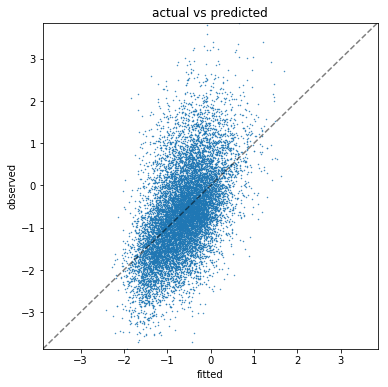

In [36]:
# plot observed (y-axis) vs fitted (x-axis)
observed = model.endog #actual response var
fitted = result.fittedvalues #predicted response var

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=fitted, y=observed, s=0.2)
ax.set_xlabel('fitted')
ax.set_ylabel('observed')
ax.set_title('actual vs predicted')

# draw a 45° y=x line
ax.set_xlim((min(np.append(observed, fitted)), max(np.append(observed, fitted))))
ax.set_ylim((min(np.append(observed, fitted)), max(np.append(observed, fitted))))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k', alpha=0.5)

plt.show()

In [37]:
# standardized residuals: the internally studentized residuals
resids_stud = result.get_influence().resid_studentized_internal

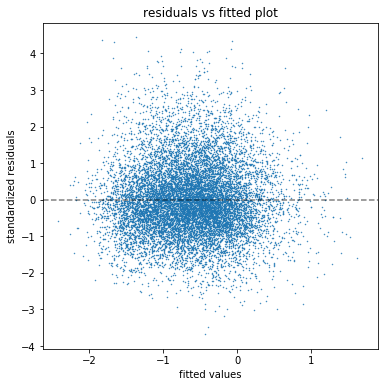

In [38]:
# residuals plot for heteroskedasticity
# want this to look like a random point pattern with no discernable trend
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=result.fittedvalues, y=resids_stud, s=0.2)
ax.axhline(y=0, ls='--', c='k', alpha=0.5)
ax.set_title('residuals vs fitted plot')
ax.set_xlabel('fitted values')
ax.set_ylabel('standardized residuals')
plt.show()

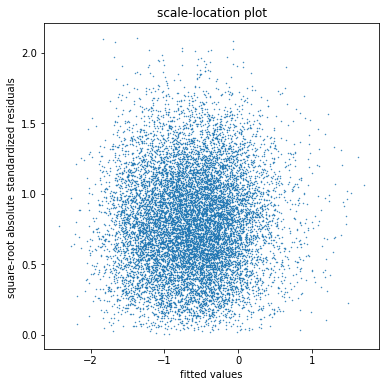

In [39]:
# scale-location plot (aka spread-location plot)
# want this to look like a random point pattern with no discernable trend
resids_stud_abs_sqrt = np.sqrt(np.abs(resids_stud))
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=result.fittedvalues, y=resids_stud_abs_sqrt, s=0.2)
ax.set_title('scale-location plot')
ax.set_xlabel('fitted values')
ax.set_ylabel('square-root absolute standardized residuals ')
plt.show()

In [40]:
# are residuals approximately normally distributed?
# null hypothesis is normal dist, p-value < 0.05 means reject null
# typically want skew and kurtosis to be within -2 to 2
# but with sufficiently large sample size, we'll always reject the null
jb, jb_p, skew, kurtosis = sms.jarque_bera(resids_stud)
print([round(x, 3) for x in [jb, jb_p, skew, kurtosis]])

[1011.988, 0.0, 0.557, 3.86]


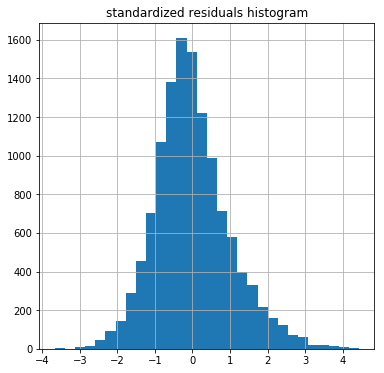

In [41]:
# are residuals approximately normally distributed?
# visuals can be more useful than test-statistics
fig, ax = plt.subplots(figsize=(6, 6))
ax = pd.Series(resids_stud).hist(bins=30, ax=ax)
ax.set_title('standardized residuals histogram')
plt.show()

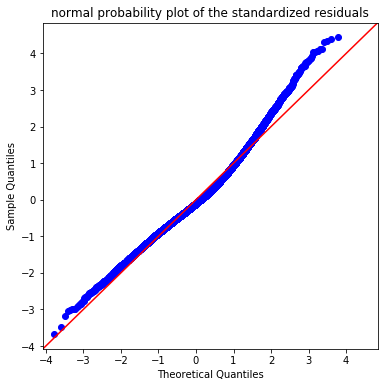

In [42]:
# are residuals approximately normally distributed?
# you want the points to tightly follow the line
# the hist above and qq plot below are ok, not terrible
fig, ax = plt.subplots(figsize=(6, 6))
fig = sm.qqplot(resids_stud, line='45', ax=ax)
ax.set_title('normal probability plot of the standardized residuals')
plt.show()

In [43]:
# create figure and axes
n = len(predictors_reduced)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))
axes = [item for sublist in axes for item in sublist]

resids_stud = result.get_influence().resid_studentized_internal

# for each axis and variable, scatterplot the resids
for ax, var in zip(axes, sorted(predictors_reduced)):
    ax.scatter(x=X[var], y=resids_stud, s=0.2)
    ax.set_xlabel(var)
    ax.set_ylabel('standardized residuals')

# save to disk and show
fig.savefig('images/scatter_resids_vs_predictors.jpg', bbox_inches='tight', dpi=150)
plt.close()

In [44]:
# outlier detection
#ot = result.outlier_test()

In [45]:
"""
ot['student_resid_abs'] = ot['student_resid'].abs()
threshold = ot['student_resid_abs'].quantile(0.99)
bad = ot[ot['student_resid_abs'] >= threshold]
df2 = df.drop(labels=bad.index)
len(df2)
"""

"\not['student_resid_abs'] = ot['student_resid'].abs()\nthreshold = ot['student_resid_abs'].quantile(0.99)\nbad = ot[ot['student_resid_abs'] >= threshold]\ndf2 = df.drop(labels=bad.index)\nlen(df2)\n"

## Regression model for just one city

In [46]:
# subset data for a single city
place_name = 'New York, NY'
df_city = df[df['place_name']==place_name]
print(sum(df_city['bias_ratio']>1), sum(df_city['bias_ratio']<=1))

449 1663


In [47]:
X_city = df_city[predictors_reduced]
print(len(X_city))
X_city = X_city.dropna()
y_city = df_city.loc[X_city.index]['bias_log']
print(len(X_city))
Xc_city = add_constant(X_city)

2112
2102


In [48]:
# estimate a model for this single city
model_city = sm.OLS(y_city, Xc_city)
result_city = model_city.fit()
print(result_city.summary())

                            OLS Regression Results                            
Dep. Variable:               bias_log   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     106.6
Date:                Fri, 09 Mar 2018   Prob (F-statistic):          1.84e-206
Time:                        17:02:24   Log-Likelihood:                -2174.1
No. Observations:                2102   AIC:                             4374.
Df Residuals:                    2089   BIC:                             4448.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [49]:
# calculate variance inflation factor just for this city
vifs_city = [vif(Xc_city.values, i) for i in range(len(Xc_city.columns))]
pd.Series(data=vifs_city, index=Xc_city.columns).sort_values(ascending=False)

const                          1334.600489
distance_to_center_km             3.150874
med_rooms_in_house                2.788354
renter_household_size             2.737785
mean_travel_time_work             2.676619
med_income_k                      2.381200
pct_white                         2.260723
pct_20_34                         2.257773
pct_college_grad_student          1.997032
pct_same_residence_year_ago       1.711940
pct_english_only                  1.664173
pct_burden                        1.360401
pct_built_before_1940             1.096039
dtype: float64

## Logit models

In [50]:
X_logit = df[predictors_reduced]
print(len(X_logit))
X_logit = X_logit.dropna()
y_logit = df.loc[X_logit.index]['is_over']
print(len(X_logit))
Xc_logit = add_constant(X_logit)

12328
12274


In [51]:
%%time
# predict whether or not tract is overrepresented on craigslist (yes/no)
model_logit = sm.Logit(y_logit, Xc_logit)
result_logit = model_logit.fit()
print(result_logit.summary())

Optimization terminated successfully.
         Current function value: 0.497194
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                is_over   No. Observations:                12274
Model:                          Logit   Df Residuals:                    12261
Method:                           MLE   Df Model:                           12
Date:                Fri, 09 Mar 2018   Pseudo R-squ.:                  0.1156
Time:                        17:02:24   Log-Likelihood:                -6102.6
converged:                       True   LL-Null:                       -6900.5
                                        LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -2.2952      0.481     -4.776      0.000   

## Dimensionality reduction

### PCA with all the predictors

In [52]:
X = df[predictors_reduced].dropna()
X = pd.DataFrame(scale(X.values), columns=X.columns)

In [53]:
# n dimensions
n = 5
pca = PCA(n_components=n)
pca.fit(X=X)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [54]:
# amount of variance that each component explains
pca.explained_variance_ratio_

array([0.292973  , 0.21605646, 0.11320983, 0.10094663, 0.0620287 ])

In [55]:
# cumulative variance explained
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3))

array([0.293, 0.509, 0.622, 0.723, 0.785])

In [56]:
labels = ['PC{}'.format(i+1) for i in range(n)]
pd.DataFrame(pca.components_, columns=X.columns, index=labels).T.sort_values('PC1', ascending=False).round(3)

,PC1,PC2,PC3,PC4,PC5
pct_college_grad_student,0.426,-0.049,-0.193,0.124,0.177
pct_20_34,0.398,-0.215,-0.144,0.229,-0.062
pct_white,0.269,0.431,-0.115,-0.023,-0.007
pct_english_only,0.185,0.280,0.382,-0.431,0.374
pct_built_before_1940,0.085,-0.198,-0.340,-0.659,-0.245
med_income_k,0.060,0.472,-0.387,0.129,-0.154
pct_burden,-0.191,-0.346,0.291,-0.102,0.273
med_rooms_in_house,-0.218,0.439,0.229,-0.182,-0.181
mean_travel_time_work,-0.273,-0.162,-0.534,-0.108,0.423
distance_to_center_km,-0.313,0.238,-0.093,0.344,0.471


### Factor analysis with all the predictors

In [57]:
# n factors
n = 5
fa = FactorAnalysis(n_components=n)
fa.fit(X=X)

C:\Anaconda\lib\site-packages\sklearn\decomposition\factor_analysis.py:228: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=5,
        noise_variance_init=None, random_state=0, svd_method='randomized',
        tol=0.01)

In [58]:
labels = ['Fac{}'.format(i+1) for i in range(n)]
pd.DataFrame(fa.components_, columns=X.columns, index=labels).T.sort_values('Fac1', ascending=False).round(3)

,Fac1,Fac2,Fac3,Fac4,Fac5
pct_built_before_1940,0.732,0.655,-0.114,-0.011,0.007
pct_college_grad_student,0.474,-0.324,0.031,0.522,0.208
pct_20_34,0.385,-0.117,0.226,0.707,0.270
pct_white,0.288,-0.478,-0.504,0.052,0.215
pct_english_only,0.274,-0.316,-0.117,-0.392,0.498
med_income_k,-0.008,-0.323,-0.890,0.196,-0.074
mean_travel_time_work,-0.041,0.390,-0.065,-0.021,-0.554
pct_burden,-0.157,0.346,0.415,-0.148,-0.028
pct_same_residence_year_ago,-0.223,0.270,-0.337,-0.408,-0.441
med_rooms_in_house,-0.354,0.030,-0.584,-0.507,0.353
